# Using Lime for Object Detection

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

Load our test image and see how it looks.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

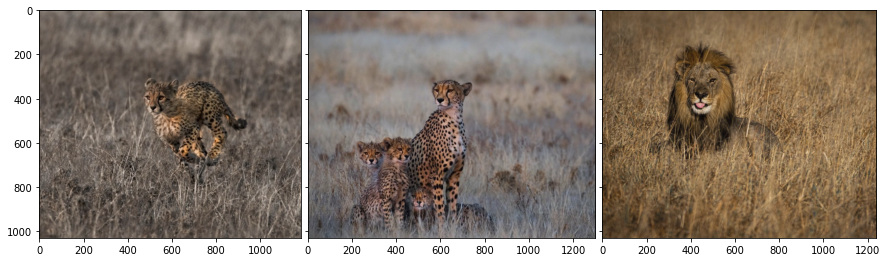

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid
img = []
img.append(get_image('./data/cheetah3.png'))
img.append(get_image('./data/cheetahs.png'))
img.append(get_image('./data/lion1.png'))

    
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, img):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)


We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [4]:
# We center crop the image with a large enough space for the main subject to be included in the picture.
# I tried 1500 pixels and it worked for all three pictures. Then using transform, we resuze the picture to 
# the size that is compatible with ImageNet based algorithms. 
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.CenterCrop(1500),
        transforms.Resize((256, 256)),        
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 available in Pytorch.

In [5]:
import time

In [6]:
transformed_images = []
nimgT = transforms.ToPILImage()
for image in img:
    get_input_tensors(image)[1:].shape
    transformed_images.append(nimgT(get_input_tensors(image).squeeze()))

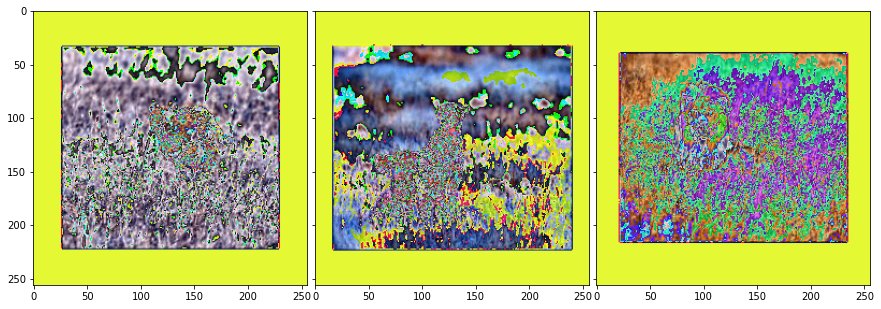

In [7]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, transformed_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    


In [8]:
model1 = models.inception_v3(pretrained=True)
model2 = models.resnet152(pretrained=True)

Load label texts for ImageNet predictions so we know what model is predicting

In [9]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

Get the predicition for our image.

In [10]:
logits1 = []
logits2 = []
for image in img:
    img_t = get_input_tensors(image)
    model1.eval()
    logits1.append(model1(img_t))
    model2.eval()
    logits2.append(model2(img_t))
    

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [11]:
probabilities1 = []
probabilities2 = []

for logits in logits1:
    probabilities1.append(F.softmax(logits, dim=1))
for logits in logits2:
    probabilities2.append(F.softmax(logits, dim=1))


In [12]:
prediction1 = []
prediction2 = []
k = 5

for p in probabilities1:
    prediction1.append(p.topk(k))

for p in probabilities2:
    prediction2.append(p.topk(k))

output1 = []
for preds in prediction1:
    tmp = tuple((idx2label[c] ,p ) for p, c in zip(preds[0][0].detach().numpy(), preds[1][0].detach().numpy()))
    output1.append(tmp)
    
output2 = []
for preds in prediction2:
    tmp = tuple((idx2label[c], p) for p, c in zip(preds[0][0].detach().numpy(), preds[1][0].detach().numpy()))
    output2.append(tmp)



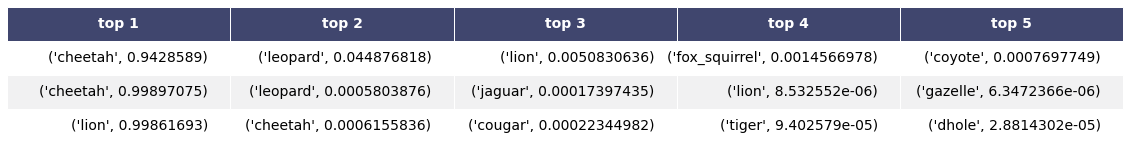

In [34]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax



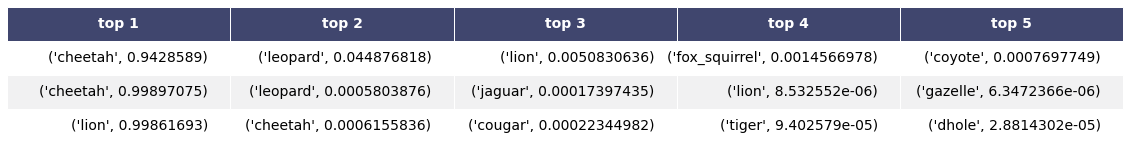

In [36]:
import pandas as pd
df1 = pd.DataFrame(output1)
#df1.index = ['image1: running cheetah cubs', 'image2: cheetah family', 'image3: lion making a face']
df1.columns = ['top 1', 'top 2', 'top 3', 'top 4', 'top 5']
df1.style.set_caption("predictions for inception V3")
fig,ax = render_mpl_table(df1, header_columns=0, col_width=4.0)
fig.savefig('data/inception.png')


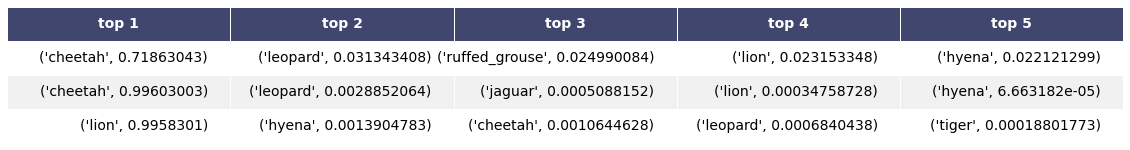

In [37]:
import pandas as pd
df2 = pd.DataFrame(output2)
#df2.index = ['image1: running cheetah cubs', 'image2: cheetah family', 'image3: lion making a face']
df2.columns = ['top 1', 'top 2', 'top 3', 'top 4', 'top 5']
df2.style.set_caption("predictions for inception V3")
fig,ax = render_mpl_table(df2, header_columns=0, col_width=4.0)
fig.savefig('data/resnet152.png')


We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [15]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

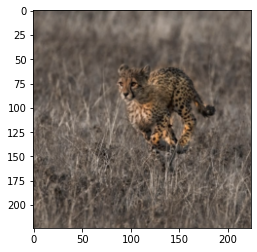

In [50]:
plt.imshow(pill_transf(img[0]))

In [75]:
np.average(preprocess_transform(pill_transf(img[0]))), np.average(t(img[0]))
np.average(range(10))

4.5

In [81]:
t = transforms.ToTensor()
pproc = preprocess_transform(pill_transf(img[0]))
pillproc = t(img[0])
(pproc.shape, pillproc.shape)

(torch.Size([3, 224, 224]), torch.Size([3, 1102, 1182]))

In [104]:
(pproc.flatten().sum(), pillproc.flatten().sum())

(tensor(-52249.3633), tensor(1466152.1250))

In [105]:
(pproc.flatten().median(), pillproc.flatten().median())

(tensor(-0.3550), tensor(0.3725))

In [106]:
(pproc.flatten().mean(), pillproc.flatten().mean())

(tensor(-0.3471), tensor(0.3752))

In [16]:
def batch_predict1(images):
    model1.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model1.to(device)
    batch = batch.to(device)
    
    logits = model1(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [17]:
def batch_predict2(images):
    model2.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model2.to(device)
    batch = batch.to(device)
    
    logits = model2(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [110]:
test_pred1 = []
test_pred2 = []
for image in img:
    test_pred1.append(batch_predict1([pill_transf(image)]).squeeze().argmax())
    test_pred2.append(batch_predict2([pill_transf(image)]).squeeze().argmax())
([idx2label[x] for x in test_pred1], [idx2label[x] for x in test_pred2])

(['cheetah', 'cheetah', 'lion'], ['cheetah', 'cheetah', 'lion'])

Import lime and create explanation for this prediciton.

[293, 293, 291]

In [19]:
from lime import lime_image

In [20]:
explainer = lime_image.LimeImageExplainer()
explanations1 = []
explanations2 = []
for image in img:
    explanations1.append(explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict1, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) )# number of images that will be sent to classification function
    explanations2.append(explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict2, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) )# number of images that will be sent to classification function
    
    
    
    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

In [121]:
a = explanations1[0]
a.get_image_and_mask(explanations1[0].top_labels[0])
a.

In [21]:
from skimage.segmentation import mark_boundaries

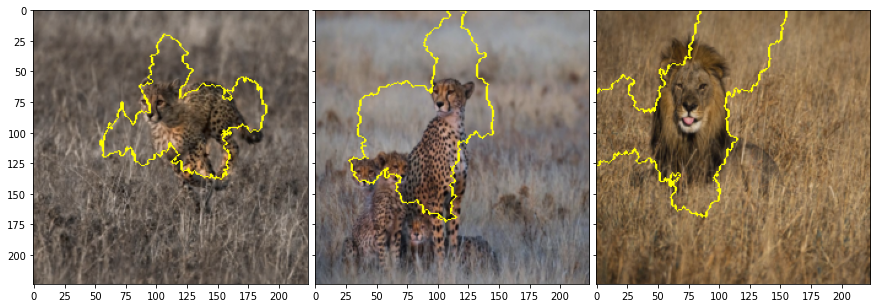

In [129]:
ib = []
for explanation in explanations1:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    ib.append(mark_boundaries(temp/255.0, mask))
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, ib):
    ax.imshow(im)


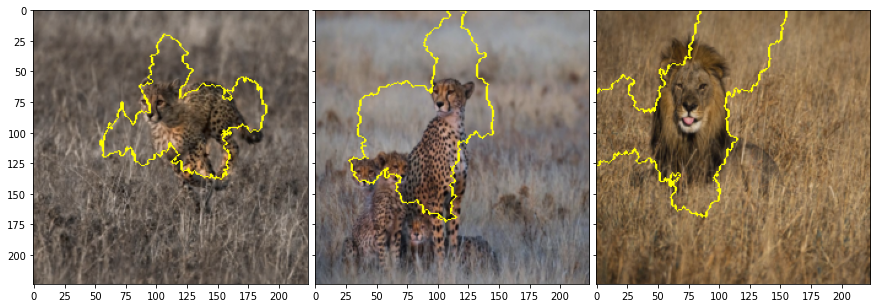

In [132]:
ib = []
for explanation in explanations1:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    ib.append(mark_boundaries(temp/255.0, mask))
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, ib):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)


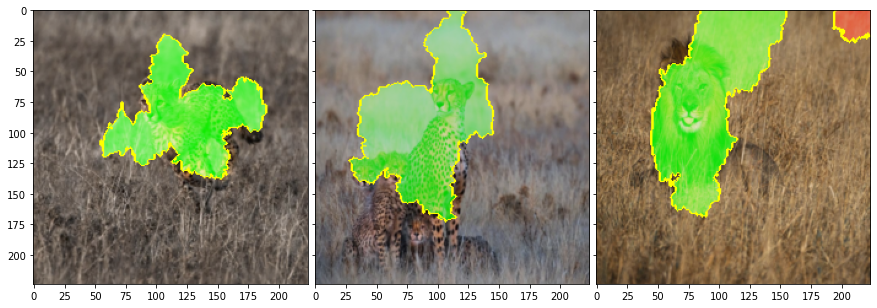

In [134]:
ib = []
for explanation in explanations1:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    ib.append(mark_boundaries(temp/255.0, mask))
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, ib):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)


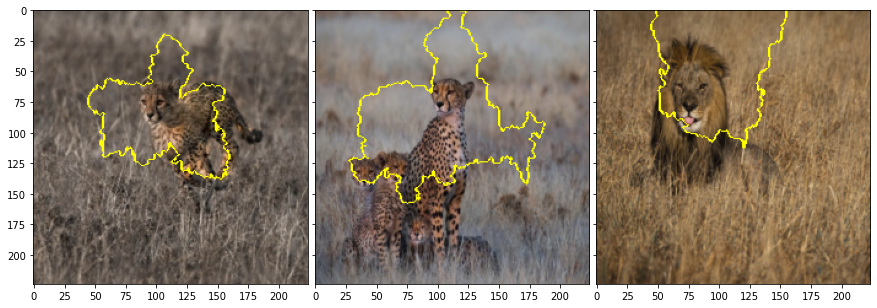

In [133]:
ib = []
for explanation in explanations2:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    ib.append(mark_boundaries(temp/255.0, mask))
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, ib):
    ax.imshow(im)


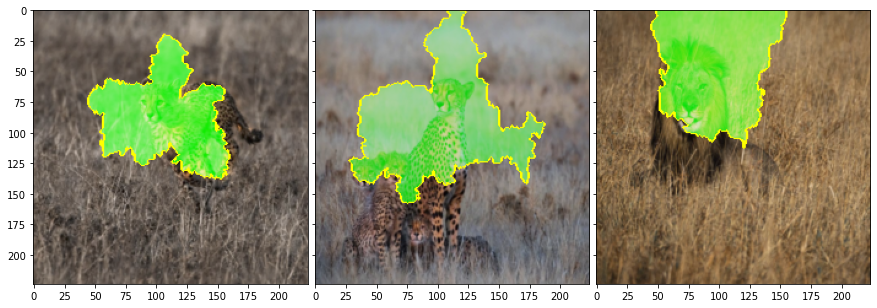

In [137]:
ib = []
for explanation in explanations2:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    ib.append(mark_boundaries(temp/255.0, mask))
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, ib):
    ax.imshow(im)


Let's turn on areas that contributes against the top prediction.